# Preprocess Event Logs for Process Prediction (Process Mining)

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from datetime import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
pd.options.display.max_columns= None
if "src" in os.getcwd():
    os.chdir("../")

## Configure

In [2]:
class EventLog:
    def __init__(self, file_path, kpi, dataset):
        self.file_path = file_path
        self.kpi = kpi
        self.dataset = dataset
        # === read file to get the dataframe
        if dataset == "bank_account_closure.csv":
            self.df = pd.read_csv(self.file_path)
            self.df[start_date_name] = pd.to_numeric( self.df[start_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
            self.df[end_date_name] = pd.to_numeric( self.df[end_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds

In [4]:
# Select the dataset to use
# data_file_path = "./data/VINST_cases_incidents_mini.csv"
# data_file_path = "./data/VINST cases incidents.csv"
# dataset = "VINST cases incidents.csv"  # VINST case incident, for Total Time KPI optimization
dataset = "bank_account_closure.csv"                # bank_account_closure, for Activity Occurrence KPI optimization

In [5]:
data_dir = "./data"
data_file_path = os.path.join(data_dir, dataset)
if dataset == "bank_account_closure.csv":
    KPI = "activity_occurrence"
    case_id_name = "REQUEST_ID"
    start_date_name = "START_DATE"
    activity_column_name = "ACTIVITY"
    resource_column_name = "CE_UO"
    role_column_name = "ROLE"
    end_date_name = "END_DATE"
    activity_to_avoid = "Back-Office Adjustment Requested"
    train_size = 0.8                  # Where the time split happens on the dataset
    df = pd.read_csv(data_file_path)  # concern: what is date col position is different?
    df[start_date_name] = pd.to_numeric( df[start_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
    df[end_date_name] = pd.to_numeric( df[end_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds

else:
    KPI = "total_time"
    case_id_name = 'SR_Number'  # The case identifier column name.
    start_date_name = 'Change_Date+Time'  # Maybe change to start_et (start even time)
    activity_column_name = "ACTIVITY"
    resource_column_name = "Involved_ST"
    role_column_name = "Involved_Org_line_3"
    end_date_name = None
    train_size = 0.8
    df = pd.read_csv(data_file_path, parse_dates=[1])  # concern: what is date col position is different?
    df[start_date_name] = df[start_date_name].view('int64') // 10**9  # 10**9 Converts nanoseconds to seconds

preprocessed_data_dir = "./preprocessed_datasets"
use_saved_model = False

In [6]:
print(f"Number of rows: {len(df):,}")
df.head()

Number of rows: 212,721


,REQUEST_ID,CLOSURE_TYPE,CLOSURE_REASON,ACTIVITY,END_DATE,START_DATE,CE_UO,ROLE
0,20175000168,Client Recess,1 - Client lost,Service closure Request with network responsib...,1539175786,1539175692,00044,APPLICANT
1,20175000168,Client Recess,1 - Client lost,Service closure Request with BO responsibility,1539602104,1539175786,BOC,BACK-OFFICE
2,20175000168,Client Recess,1 - Client lost,Pending Request for Reservation Closure,1539602345,1539602104,BOC,BACK-OFFICE
3,20175000168,Client Recess,1 - Client lost,Pending Liquidation Request,1539745391,1539602345,BOC,BACK-OFFICE
4,20175000168,Client Recess,1 - Client lost,Request completed with account closure,1539745391,1539745391,BOC,BACK-OFFICE


## Clean the Dataset

In [7]:
def move_essential_columns(df, case_id_name: str, start_date_name: str) -> pd.DataFrame:
    """
    Puts the column `case_id_name` and `start_date_name` in start and then the rest of the
    columns
    """
    columns = df.columns.to_list()
    columns.remove(case_id_name)
    columns.remove(start_date_name)
    df = df[[case_id_name, start_date_name] + columns]
    return df

def sort_df_case_id_n_time(df, case_id_name: str, start_date_name: str) -> pd.DataFrame:
    """ Sorts in ascending order according the case-ids and start-date time """
    df = df.sort_values([case_id_name, start_date_name], axis=0, ascending=True, kind='quicksort', na_position='last')
    return df

In [8]:
df = df.fillna("missing")  # Replace all NaN values with the keyword "missing
df = move_essential_columns(df, case_id_name, start_date_name)
# Maybe use this or the function
df = df.sort_values([case_id_name, start_date_name], axis=0, ascending=True, kind='quicksort', na_position='last')

## Preprocess the dataset

In [9]:
# === Fix Time Columns (temporary)
# if dataset == "bank_account_closure.csv":
#     df[start_date_name] = pd.to_datetime( df[start_date_name], unit='s')
#     df[end_date_name] = pd.to_datetime( df[end_date_name], unit='s')
#     df.to_csv("bank-acc_v2.csv", index=False)

In [10]:
# ====== For developing attributes that are specific to an entire trace
# gdf = df.groupby(case_id_name)
# for case_id, group in gdf:
#     print(group)
#     if end_date_name is not None:
#         print( group[end_date_name] - group[start_date_name] )
#     break

In [11]:
def get_time_from_midnight(dt_obj: pd.Timestamp) -> int:
    """
    :param dt_obj: Is a datetime object.
    Return seconds elapsed from midnight (or day start 00:00:00)
    """
    return dt_obj.hour * 3600 + dt_obj.minute * 60 + dt_obj.second

def add_features(df, case_id_name: str, start_date_name: str, end_date_name=None) -> pd.DataFrame:
    """
    Times that are integer are in seconds.
    """
    df["time_from_first"] = 0
    df["time_from_previous_et"] = 0
    df["time_from_midnight"] = 0
    df["weekday"] = 0
    if end_date_name is not None:
        df["activity_duration"] = 0
    df["time_remaining"] = 0

    gdf = df.groupby(case_id_name)
    i = 0
    for case_id, group in gdf:

        case_first_time = group[start_date_name].min()  # The timestamp at the first event of the 'case'
        case_last_time = group[start_date_name].max()   # The timestamp of the last event of the 'case'.
        # Note last event may not be the ending or final event e.g. a running case.

        # Expression in brackets return a series, we apply the desired function on all elements using .apply(...)
        time_from_first = group[start_date_name] - case_first_time

        time_from_previous_et =  group[start_date_name].diff()
        time_from_previous_et = time_from_previous_et.fillna(0)  # edge case where is first row has a zero

        time_from_midnight = pd.to_datetime( group[start_date_name], unit='s' ).apply(lambda x: get_time_from_midnight(x))

        # dt: Accessor object for datetimelike properties of the Series' values.
        weekday_number = pd.to_datetime( group[start_date_name], unit='s' ).dt.dayofweek
        weekday_str = weekday_number.replace({0: "Monday", 1: "Tuesday", 2: "Wednesday",
                                              3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})
        if end_date_name is not None:
            activity_duration = group[end_date_name] - group[start_date_name]
            df.loc[group.index, "activity_duration"] = activity_duration

        time_remaining = case_last_time - group[start_date_name]

        # # # Set values in the dataframe at the index corresponding to the group's case-id.
        # Maybe possible to optimize.
        # Possible way 1: Create a mini-df from group augment it with new features and at the end pd.concat all the mini-dfs
        df.loc[group.index, "time_from_first"] = time_from_first
        df.loc[group.index, "time_from_previous_et"] = time_from_previous_et
        df.loc[group.index, "time_from_midnight"] = time_from_midnight
        df.loc[group.index, "weekday"] = weekday_str
        df.loc[group.index, "time_remaining"] = time_remaining

    return df
"""
Given a trace we want to create all prefixes of it. E.g. trace: <a, b, c> then prefixes: {<a>, <a,b>, <a,b,c>}.
Here the letters denote activities. Next, just like a trace has a KPI value, all its prefixes are associated
with the same prefix value.

This function implements the aggregated history version of creating prefixes from traces. The idea is that we
create a different column for each activity, then within a trace (or case) the counter value keeps track of how many
times an activity has occurred. View the before and after CSVs for a better understanding.
"""

def add_aggregated_history(df, case_id_name, activity_column_name) -> pd.DataFrame:

    for activity in df[activity_column_name].unique():
        df[f"# {activity_column_name}={activity}"] = 0
        # first put 1 in correspondence to each activity
        df.loc[df[activity_column_name] == activity, f"# {activity_column_name}={activity}"] = 1
        # sum the count from the previous events
        df[f"# {activity_column_name}={activity}"] = df.groupby(case_id_name)[f"# {activity_column_name}={activity}"].cumsum()
    return df

def change_history(df, activity_column_name="ACTIVITY"):
    for i, row in df.iterrows():
        act = df.at[i, activity_column_name]
        if df.at[i, '# ' + activity_column_name + '=' + act] != 0:
            df.at[i, '# ' + activity_column_name + '=' + act] -= 1
    return df

In [12]:
df = add_features(df, case_id_name, start_date_name, end_date_name)
df = add_aggregated_history(df, case_id_name, activity_column_name)
df = change_history(df, activity_column_name=activity_column_name)

In [13]:
df[:6]

,REQUEST_ID,START_DATE,CLOSURE_TYPE,CLOSURE_REASON,ACTIVITY,END_DATE,CE_UO,ROLE,time_from_first,time_from_previous_et,time_from_midnight,weekday,activity_duration,time_remaining,# ACTIVITY=Service closure Request with network responsibility,# ACTIVITY=Service closure Request with BO responsibility,# ACTIVITY=Pending Request for Reservation Closure,# ACTIVITY=Pending Liquidation Request,# ACTIVITY=Request completed with account closure,# ACTIVITY=Request created,# ACTIVITY=Authorization Requested,# ACTIVITY=Evaluating Request (NO registered letter),# ACTIVITY=Network Adjustment Requested,# ACTIVITY=Pending Request for acquittance of heirs,# ACTIVITY=Request deleted,# ACTIVITY=Back-Office Adjustment Requested,# ACTIVITY=Evaluating Request (WITH registered letter),# ACTIVITY=Request completed with customer recovery,# ACTIVITY=Pending Request for Network Information
0,20175000168,1539175692,Client Recess,1 - Client lost,Service closure Request with network responsib...,1539175786,00044,APPLICANT,0,0,46092,Wednesday,94,569699,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20175000168,1539175786,Client Recess,1 - Client lost,Service closure Request with BO responsibility,1539602104,BOC,BACK-OFFICE,94,94,46186,Wednesday,426318,569605,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20175000168,1539602104,Client Recess,1 - Client lost,Pending Request for Reservation Closure,1539602345,BOC,BACK-OFFICE,426412,426318,40504,Monday,241,143287,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20175000168,1539602345,Client Recess,1 - Client lost,Pending Liquidation Request,1539745391,BOC,BACK-OFFICE,426653,241,40745,Monday,143046,143046,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,20175000168,1539745391,Client Recess,1 - Client lost,Request completed with account closure,1539745391,BOC,BACK-OFFICE,569699,143046,10991,Wednesday,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
5,20175000642,1541672782,Bank Recess,1 - Client lost,Request created,1541672852,00624,APPLICANT,0,0,37582,Thursday,70,578503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Base on the KPI create the label (or y) column.
This column is maybe the KPI column for a given prefix? (? means not sure)
### KPI Activity Occurrence
TODO
- Ask: If the activity occurs more than once in the trace, This code puts 0 from the 1st occurrence, but the OG code puts 0 from the last occurrence.
       Which is the correct behavior?
-

In [14]:
def add_act_to_stop(df, activity_column_name=activity_column_name, activity_to_avoid=None):
    """
    Args:
        df (pd.DataFrame):
        activity_to_avoid: A column of this activity name is added. Next, if an activity with this value is present
                        in a trace, the trace rows, till the activity row, get a value of 1. This 1 is placed in
                        the column labelled `activity_to_avoid`.
    Returns:
        df (pd.DataFrame):
    """
    df[ activity_to_avoid ] = 0
    gdf = df.groupby(case_id_name)
    i = 0

    for case_id, group in gdf:

        # If activity_to_stop is in the trace
        if activity_to_avoid in group[activity_column_name].to_list():
            # print( activity_to_stop in group[activity_column_name].to_list() )
            pass

            # Get index of first occurrence of the activity_to_stop
            # print( group.index[ group[activity_column_name] == activity_to_avoid ].values[0] )
            index_of_first_occurrence = group.index[group[activity_column_name] == activity_to_avoid].values[0]

            # Using group.loc makes sure the scope of assignment starts from the start of the trace only
            # Rest of the dataframe is not affected.
            # -1, cuz we don't want value of `1` in the row of activity_to_stop & with .loc the end is inclusive
            group.loc[ :index_of_first_occurrence - 1, activity_to_avoid ] = 1
            # print("==", group.loc[ :index_of_first_occurrence - 1, : ] )

            # using group.index is safer to access the main dataframe. This access the part of the main dataframe
            # that corresponds to the group dataframe slice.
            df.loc[ group.index, activity_to_avoid ] = group[activity_to_avoid]
            # print( df.loc[ group.index, activity_to_stop ] )
            # print( group.index )
        i += 1
        # if i == 30:
        #     break

    return df

In [15]:
if KPI == "total_time":
    leadtime_per_case = df.groupby(case_id_name).agg("first")["time_remaining"]
    df["lead_time"] = df[case_id_name].map(leadtime_per_case)
    target_column_name = 'lead_time'
elif KPI == "activity_occurrence":
    # In this case activity_to_avoid becomes the target (or y) column for the ML problem.
    df = add_act_to_stop(df, activity_column_name=activity_column_name, activity_to_avoid=activity_to_avoid)


In [16]:
def remove_two_step_traces(df):
    """
    Removes cases with trace length of 2 originally, thus when time_remaining = 0 row is
    removed the length becomes less than (lt) 2.
    """
    gdf = df.groupby(case_id_name)
    indexes_to_drop = []
    # i = 0
    for case_id, group in gdf:

        if len(group) < 2:
            indexes_to_drop.extend(group.index)

        # i += 1
        # if i == 4:
        #     break

    df = df.drop( indexes_to_drop ).reset_index(drop=True)
    return df

# ------ temp

In [17]:
# gdf = df.groupby(case_id_name)
# indexes_to_drop = []
# # i = 0
# for case_id, group in gdf:
#     if len(group) <= 2:
#         # print( case_id )
#         indexes_to_drop.append(case_id)
#
# df_temp = pd.DataFrame(columns=df.columns)
# for case_id in indexes_to_drop:
#     df_small = df[df[case_id_name] == case_id].copy()
#     df_temp = pd.concat([df_temp, df_small], axis='rows')
# # le: less than or equal to
# # df_temp.to_csv(f"{dataset}-size_le_2-cases.csv", index=False)
# print( f"Cases with trace length le 2 are: { len(indexes_to_drop) }", "le & eq linux bash comparison operator convention" )
#
#
# gdf = df.groupby(case_id_name)
# indexes_to_drop = []
# # i = 0
# for case_id, group in gdf:
#     if len(group) == 3:
#         # print( case_id )
#         indexes_to_drop.append(case_id)
#
# df_temp = pd.DataFrame(columns=df.columns)
# for case_id in indexes_to_drop:
#     df_small = df[df[case_id_name] == case_id].copy()
#     df_temp = pd.concat([df_temp, df_small], axis='rows')
# # le: less than or equal to
# # df_temp.to_csv(f"{dataset}-size_eq_3-cases.csv", index=False)
# print( f"Cases with trace length eq 3 are: { len(indexes_to_drop) }" )

# ----------

In [18]:
# Remove rows where remaining_time=0
df = df.drop( df.index[ df["time_remaining"] == 0 ] ).reset_index(drop=True)

# Remove rows where with trace length < 2
before_cases = len(df[case_id_name].unique())
df = remove_two_step_traces(df)

after_cases = len(df[case_id_name].unique())
print(f"Number of cases Before: {before_cases:,}")
print(f"Number of cases with length less than 2: {(before_cases - after_cases):,}")
print(f"Percentage of cases dropped: {( (before_cases - after_cases) / before_cases) * 100}%")
print(f"Number of cases After: {after_cases:,}")

Number of cases Before: 32,429
Number of cases with length less than 2: 3,235
Percentage of cases dropped: 9.975639088470196%
Number of cases After: 29,194


In [19]:
# """
# Not sure why the target_column is created and later on merged anyway
# """
# target_column = df[target_column_name].copy()
# df = df.drop(columns=[target_column_name, "time_remaining"])

In [20]:
df.head()

,REQUEST_ID,START_DATE,CLOSURE_TYPE,CLOSURE_REASON,ACTIVITY,END_DATE,CE_UO,ROLE,time_from_first,time_from_previous_et,time_from_midnight,weekday,activity_duration,time_remaining,# ACTIVITY=Service closure Request with network responsibility,# ACTIVITY=Service closure Request with BO responsibility,# ACTIVITY=Pending Request for Reservation Closure,# ACTIVITY=Pending Liquidation Request,# ACTIVITY=Request completed with account closure,# ACTIVITY=Request created,# ACTIVITY=Authorization Requested,# ACTIVITY=Evaluating Request (NO registered letter),# ACTIVITY=Network Adjustment Requested,# ACTIVITY=Pending Request for acquittance of heirs,# ACTIVITY=Request deleted,# ACTIVITY=Back-Office Adjustment Requested,# ACTIVITY=Evaluating Request (WITH registered letter),# ACTIVITY=Request completed with customer recovery,# ACTIVITY=Pending Request for Network Information,Back-Office Adjustment Requested
0,20175000168,1539175692,Client Recess,1 - Client lost,Service closure Request with network responsib...,1539175786,00044,APPLICANT,0,0,46092,Wednesday,94,569699,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20175000168,1539175786,Client Recess,1 - Client lost,Service closure Request with BO responsibility,1539602104,BOC,BACK-OFFICE,94,94,46186,Wednesday,426318,569605,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20175000168,1539602104,Client Recess,1 - Client lost,Pending Request for Reservation Closure,1539602345,BOC,BACK-OFFICE,426412,426318,40504,Monday,241,143287,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20175000168,1539602345,Client Recess,1 - Client lost,Pending Liquidation Request,1539745391,BOC,BACK-OFFICE,426653,241,40745,Monday,143046,143046,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20175000642,1541672782,Bank Recess,1 - Client lost,Request created,1541672852,00624,APPLICANT,0,0,37582,Thursday,70,578503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Split the Dataset for Machine Learning

We are going to train and test the model with the following split:
### For KPI Total Time
* Train: 80% cases
* Test: 20 % cases
### For KPI Activity Occurrence
- split on time, to avoid future leak in the testing data.
- Make the time split such that cases with `activity_to_avoid` are 70% int trainset and 30% in testset.
  - To do this, iteratively split and check percentage of `activity_to_avoid` cases in the trainset
- Train: Mix the rest of the cases with 2/3 training mix
- Test: Keep only the 1/3 testing mix

In [21]:
# if KPI == "total_time":
#     cases = df[case_id_name].unique()
#     train_n_valid_cases, test_cases = train_test_split(cases, train_size=0.67, test_size=0.33)
#     train_cases, valid_cases = train_test_split(train_n_valid_cases, train_size=0.80)
#
#     df_train = df[df[case_id_name].isin(train_cases)].copy()
#     df_train = df_train.reset_index(drop=True)
#     df_valid = df[df[case_id_name].isin(valid_cases)].copy()
#     df_valid = df_valid.reset_index(drop=True)
#     df_test = df[df[case_id_name].isin(test_cases)].copy()
#     df_test = df_test.reset_index(drop=True)
#
#     df_train.to_csv( os.path.join(preprocessed_data_dir, "train-set-cfe.csv"), index=False)
#     df_test.to_csv( os.path.join(preprocessed_data_dir, "test-set-cfe.csv"), index=False)

# # Old split comment later
# if KPI == "activity_occurrence":
#     # === How much traces have `activity_to_avoid`
#     case_ids_with_activity_to_avoid = []
#     case_ids_without_activity_to_avoid = []
#     gdf = df.groupby(case_id_name)
#     for case_id, group in gdf:
#         if activity_to_avoid in group[activity_column_name].to_list():
#             case_ids_with_activity_to_avoid.append(case_id)
#         else:
#             case_ids_without_activity_to_avoid.append(case_id)
#     print(f"Cases with activity_to_avoid: {len(case_ids_with_activity_to_avoid):,}")
#     print(f"Cases without activity_to_avoid: {len(case_ids_without_activity_to_avoid):,}")
#
#     # Split the `activity_to_avoid` cases for train and test
#     train_cases, test_cases = train_test_split(case_ids_with_activity_to_avoid, train_size=0.75)
#
#     # Split the other cases for train and test
#     temp_train, temp_test = train_test_split(case_ids_without_activity_to_avoid, train_size=0.999)
#
#
#     # === Combine training split with rest of the cases
#     # train_cases = train_cases + case_ids_without_activity_to_avoid
#
#     train_cases += temp_train
#     test_cases += temp_test
#
#     random.shuffle( train_cases )
#     random.shuffle( test_cases )
#
#     df_train = df[df[case_id_name].isin(train_cases)].copy()
#     df_train = df_train.reset_index(drop=True)
#     df_test = df[df[case_id_name].isin(test_cases)].copy()
#     df_test = df_test.reset_index(drop=True)
#
#     df_train.to_csv( os.path.join(preprocessed_data_dir, "old_bank_acc_train.csv"), index=False)
#     df_test.to_csv( os.path.join(preprocessed_data_dir, "old_bank_acc_test.csv"), index=False)

### Another type of Split

In [22]:
def cases_with_activity_to_avoid(df, activity_column_name, activity_to_avoid):
    """
    Returns:
        case_ids_with_activity_to_avoid, case_ids_without_activity_to_avoid
    """
    # === How much traces have `activity_to_avoid`
    case_ids_with_activity_to_avoid = []
    case_ids_without_activity_to_avoid = []
    gdf = df.groupby(case_id_name)
    for case_id, group in gdf:
        if activity_to_avoid in group[activity_column_name].to_list():
            case_ids_with_activity_to_avoid.append(case_id)
        else:
            case_ids_without_activity_to_avoid.append(case_id)
    # print(f"Cases with activity_to_avoid: {len(case_ids_with_activity_to_avoid):,}")
    # print(f"Cases without activity_to_avoid: {len(case_ids_without_activity_to_avoid):,}")
    return case_ids_with_activity_to_avoid, case_ids_without_activity_to_avoid

Total cases: 29194
Total cases with activity_to_avoid: 3320
Desired number of cases with activity_to_avoid in trainset: 2656.0
Starting splitting procedure..
length of start_end_couple: 29,194
The min max range is 1970-01-01 00:00:01.496047666, 1970-01-01 00:00:01.551697002
With length 1970-01-01 00:00:00.055649336


100%|██████████| 10002/10002 [03:46<00:00, 44.09it/s]
/tmp/ipykernel_2185448/1128623571.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_idxs = start_end_couple[start_end_couple['end'] >= thrs][start_end_couple['start'] <= thrs]['idx'].values


Threshold: 2019-02-08 15:35:14
Condition for train_idxs = start_end_couple['end'] <= 2019-02-08 15:35:14
Condition for test_idxs = start_end_couple['end'] >= 2019-02-08 15:35:14 and start_end_couple['start'] <= 2019-02-08 15:35:14
Number of runnning Test Cases: 1831
train_idxs after thrs = 25710
train_idxs after thrs = 3484
Split done
Total cases: 29194
Cases in df_train: 25710
Cases in df_test: 3484
Number of cases with activity_to_avoid in trainset: 2997 with train_size = 0.87
Number of cases with activity_to_avoid in testset: 323 with train_size = 0.87


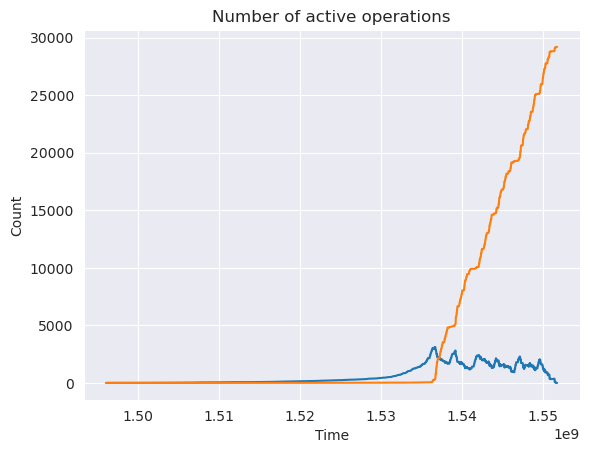

In [28]:
# Iteratively Check where to do the time split (what value for train_size to put)
if KPI == "activity_occurrence":
    # def get_split_indexes(df, case_id_name, start_date_name, train_size=float):
    #     print('Starting splitting procedure..')
    #     start_end_couple = list()
    #     for idx in df[case_id_name].unique():
    #         df_ = df[df[case_id_name] == idx].reset_index(drop=True)
    #         start_end_couple.append([idx, df_[start_date_name].values[0], df_[start_date_name].values[len(df_) - 1]])
    #     start_end_couple = pd.DataFrame(start_end_couple, columns=['idx', 'start', 'end'])
    #     print(f"length of start_end_couple: {len(start_end_couple):,}")  # temp
    #     print(f"The min max range is {pd.to_datetime( start_end_couple.start.min(), unit='s' )}, {pd.to_datetime( start_end_couple.end.max(), unit='s' )}")
    #     print(f"With length { start_end_couple.end.max() - start_end_couple.start.min()}")
    #     # Initialize pdf of active cases and cdf of closed cases
    #     # times_dict_pdf = dict()
    #     # times_dict_cdf = dict()
    #     # split = int((start_end_couple.end.max() - start_end_couple.start.min()) / 10_000)  # In order to get a 10000 dotted graph
    #     # for time in range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split):
    #     #     times_dict_pdf[time] = 0
    #     #     times_dict_cdf[time] = 0
    #     # for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
    #     #     for line in np.array(start_end_couple[['start', 'end']]):
    #     #         line = np.array(line)
    #     #         if (line[0] <= time) and (line[1] >= time):
    #     #             times_dict_pdf[time] += 1
    #     # for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
    #     #     for line in np.array(start_end_couple[['start', 'end']]):
    #     #         line = np.array(line)
    #     #         if (line[1] <= time):  # Keep just k closes cases
    #     #             times_dict_cdf[time] += 1
    #     # sns.set_style('darkgrid')
    #     # plt.title('Number of active operations')
    #     # plt.xlabel('Time')
    #     # plt.ylabel('Count')
    #
    #     # times_pdf_df = pd.DataFrame( {"time": list(times_dict_pdf.keys()), "count": list(times_dict_pdf.values())} )
    #     # times_cdf_df = pd.DataFrame( {"time": list(times_dict_cdf.keys()), "count": list(times_dict_cdf.values())} )
    #     #
    #     # sns.lineplot(data=times_pdf_df, x="time", y="count")
    #     # sns.lineplot(data=times_cdf_df, x="time", y="count")
    #     # plt.savefig('Active and completed cases distribution.png')
    #     # times_dist = pd.DataFrame(columns=['times', 'pdf_active', 'cdf_closed'])
    #     # times_dist['times'] = times_dict_pdf.keys()
    #     # times_dist['pdf_active'] = times_dict_pdf.values()
    #     # times_dist['cdf_closed'] = np.array(list(times_dict_cdf.values())) / (len(df[case_id_name].unique()))
    #     # # Set threshold after 60 of closed activities (it'll be the train set)
    #     # test_dim = times_dist[times_dist.cdf_closed > train_size].pdf_active.max()
    #     # thrs = times_dist[times_dist.pdf_active == test_dim].times.values[0]
    #
    #     # ===== Manually modify the date to get the precious threshold value
    #     date_string = "2019-01-01 00:00:00"
    #     format_string = "%Y-%m-%d %H:%M:%S"
    #
    #     # Convert the date string to a datetime object
    #     datetime_obj = datetime.strptime(date_string, format_string)
    #
    #     # Convert the datetime object to an epoch timestamp
    #     thrs = int( datetime_obj.timestamp() )
    #
    #     print(f"Threshold: { pd.to_datetime(thrs, unit='s') }")
    #     print(f"Condition for train_idxs = {start_end_couple[start_end_couple['end'] <= thrs].values[-1] } <= threshold")
    #     print(f"Condition for test_idxs = {start_end_couple[start_end_couple['end'] >= thrs].values[0]} >= threshold")
    #     train_idxs = start_end_couple[start_end_couple['end'] <= thrs]['idx'].values
    #     # test_idxs = start_end_couple[start_end_couple['end'] >= thrs]['idx'].values   # (start_end_couple['end'] >= thrs) is redundant
    #     test_idxs = start_end_couple[ (thrs <= start_end_couple['start']) ]['idx'].values
    #
    #     print(f"train_idxs after thrs = {len(train_idxs)}")  # temp
    #     print(f"train_idxs after thrs = {len(test_idxs)}")  # temp
    #
    #     with open(f'indexes/train_idx_{case_id_name}.pkl', 'wb') as file_handle:
    #         pickle.dump(train_idxs, file_handle)
    #     with open(f'indexes/test_idx_{case_id_name}.pkl', 'wb') as file_handle:
    #         pickle.dump(test_idxs, file_handle)
    #     print('Split done')

    def get_split_indexes(df, case_id_name, start_date_name, train_size=float):
        print('Starting splitting procedure..')
        start_end_couple = list()
        for idx in df[case_id_name].unique():
            df_ = df[df[case_id_name] == idx].reset_index(drop=True)
            start_end_couple.append([idx, df_[start_date_name].values[0], df_[start_date_name].values[len(df_) - 1]])
        start_end_couple = pd.DataFrame(start_end_couple, columns=['idx', 'start', 'end'])
        print(f"length of start_end_couple: {len(start_end_couple):,}")  # temp
        print(f'The min max range is {pd.to_datetime( start_end_couple.start.min() )}, {pd.to_datetime( start_end_couple.end.max() )}')
        print(f'With length {pd.to_datetime(start_end_couple.end.max() - start_end_couple.start.min() )}')
        # Initialize pdf of active cases and cdf of closed cases
        times_dict_pdf = dict()
        times_dict_cdf = dict()
        split = int((start_end_couple.end.max() - start_end_couple.start.min()) / 10000)  # In order to get a 10000 dotted graph
        for time in range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split):
            times_dict_pdf[time] = 0
            times_dict_cdf[time] = 0
        for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
            for line in np.array(start_end_couple[['start', 'end']]):
                line = np.array(line)
                if (line[0] <= time) and (line[1] >= time):
                    times_dict_pdf[time] += 1
        for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
            for line in np.array(start_end_couple[['start', 'end']]):
                line = np.array(line)
                if (line[1] <= time):  # Keep just k closes cases
                    times_dict_cdf[time] += 1
        sns.set_style('darkgrid')
        plt.title('Number of active operations')
        plt.xlabel('Time')
        plt.ylabel('Count')

        times_pdf_df = pd.DataFrame( {"time": list(times_dict_pdf.keys()), "count": list(times_dict_pdf.values())} )
        times_cdf_df = pd.DataFrame( {"time": list(times_dict_cdf.keys()), "count": list(times_dict_cdf.values())} )

        sns.lineplot(data=times_pdf_df, x="time", y="count")
        sns.lineplot(data=times_cdf_df, x="time", y="count")
        plt.savefig('Active and completed cases distribution.png')
        times_dist = pd.DataFrame(columns=['times', 'pdf_active', 'cdf_closed'])
        times_dist['times'] = times_dict_pdf.keys()
        times_dist['pdf_active'] = times_dict_pdf.values()
        times_dist['cdf_closed'] = np.array(list(times_dict_cdf.values())) / (len(df[case_id_name].unique()))
        # Set threshold after 60 of closed activities (it'll be the train set)
        test_dim = times_dist[times_dist.cdf_closed > train_size].pdf_active.max()
        thrs = times_dist[times_dist.pdf_active == test_dim].times.values[0]
        thrs_h = pd.to_datetime(thrs, unit='s')
        print(f"Threshold: {thrs_h}")
        print(f"Condition for train_idxs = start_end_couple['end'] <= {thrs_h}")
        print(f"Condition for test_idxs = start_end_couple['end'] >= {thrs_h} and start_end_couple['start'] <= {thrs_h}")
        train_idxs = start_end_couple[start_end_couple['end'] <= thrs]['idx'].values
        test_idxs = start_end_couple[start_end_couple['end'] >= thrs][start_end_couple['start'] <= thrs]['idx'].values
        print(f"Number of runnning Test Cases: {len(test_idxs)}")
        test_idxs = np.append( test_idxs, start_end_couple[start_end_couple['start'] >= thrs]['idx'].values )

        print(f"train_idxs after thrs = {len(train_idxs)}")  # temp
        print(f"train_idxs after thrs = {len(test_idxs)}")  # temp

        with open(f'indexes/train_idx_{case_id_name}.pkl', 'wb') as file_handle:
            pickle.dump(train_idxs, file_handle)
        with open(f'indexes/test_idx_{case_id_name}.pkl', 'wb') as file_handle:
            pickle.dump(test_idxs, file_handle)
        print('Split done')

    print(f"Total cases: {len(df[case_id_name].unique())}")
    case_ids_with_activity_to_avoid, _ = cases_with_activity_to_avoid(df, activity_column_name, activity_to_avoid)
    print(f"Total cases with activity_to_avoid: {len(case_ids_with_activity_to_avoid)}")
    print(f"Desired number of cases with activity_to_avoid in trainset: {len(case_ids_with_activity_to_avoid) * 0.80 }")

    get_split_indexes(df, case_id_name, start_date_name, train_size=0.88)

    with open(f'indexes/train_idx_{case_id_name}.pkl', 'rb') as file_handle:
        train_idxs = pickle.load(file_handle)
    with open(f'indexes/test_idx_{case_id_name}.pkl', 'rb') as file_handle:
        test_idxs = pickle.load(file_handle)

    df_train = df[df[case_id_name].isin(train_idxs)].copy()
    df_train = df_train.reset_index(drop=True)
    df_test = df[df[case_id_name].isin(test_idxs)].copy()
    df_test = df_test.reset_index(drop=True)

    total_cases = len(df_train[case_id_name].unique()) + len(df_test[case_id_name].unique())
    print(f"Total cases: { total_cases }")
    print(f"Cases in df_train: {len(df_train[case_id_name].unique())}")
    print(f"Cases in df_test: {len(df_test[case_id_name].unique())}")

    case_ids_with_activity_to_avoid_train, _ = cases_with_activity_to_avoid(df_train, activity_column_name, activity_to_avoid)
    case_ids_with_activity_to_avoid_test, _ = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
    print(f"Number of cases with activity_to_avoid in trainset: {len(case_ids_with_activity_to_avoid_train)} with train_size = {0.87}")
    print(f"Number of cases with activity_to_avoid in testset: {len(case_ids_with_activity_to_avoid_test)} with train_size = {0.87}")
    # Total case after: 27,780x

In [38]:
# 9,411 test cases are too much, we'll keep the 760 important ones, which have the `activity_to_avoid` and 240 random cases.
if KPI == "activity_occurrence":
    # Sample 240 random cases from the testset
    _, case_ids_without_activity_to_avoid_test = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
    test_cases_to_keep = random.sample(case_ids_without_activity_to_avoid_test, 215)

    # remove these 240 cases from the case_ids_without_activity_to_avoid_test to get the remainder of the indexes to add to the train_idxs
    remaining_test_cases = list(filter(lambda x: x not in test_cases_to_keep, case_ids_without_activity_to_avoid_test))

    train_idxs = list(train_idxs)
    test_idxs = list(test_idxs)
    train_idxs += remaining_test_cases
    test_idxs = case_ids_with_activity_to_avoid_test + test_cases_to_keep

    # Sanity check to verify everything
    df_train = df[df[case_id_name].isin(train_idxs)].copy()
    df_train = df_train.reset_index(drop=True)
    df_test = df[df[case_id_name].isin(test_idxs)].copy()
    df_test = df_test.reset_index(drop=True)

    total_cases = len(df_train[case_id_name].unique()) + len(df_test[case_id_name].unique())
    print(f"Total cases: { total_cases }")
    print(f"Cases in df_train: {len(df_train[case_id_name].unique())}")
    print(f"Cases in df_test: {len(df_test[case_id_name].unique())}")

    case_ids_with_activity_to_avoid_train, _ = cases_with_activity_to_avoid(df_train, activity_column_name, activity_to_avoid)
    case_ids_with_activity_to_avoid_test, _ = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
    print(f"Number of cases with activity_to_avoid in trainset: {len(case_ids_with_activity_to_avoid_train)} with train_size = {train_size}")
    print(f"Number of cases with activity_to_avoid in testset: {len(case_ids_with_activity_to_avoid_test)} with train_size = {train_size}")

    # If everything is okay save the dataframes (uncomment the below lines)
    df_train.to_csv( os.path.join(preprocessed_data_dir, "bank_acc_train.csv"), index=False)
    df_test.to_csv( os.path.join(preprocessed_data_dir, "bank_acc_test.csv"), index=False)

Total cases: 28174
Cases in df_train: 27274
Cases in df_test: 900
Number of cases with activity_to_avoid in trainset: 2440 with train_size = 0.8
Number of cases with activity_to_avoid in testset: 685 with train_size = 0.8


In [62]:
if KPI == "total_time":
    def get_split_indexes(df, case_id_name, start_date_name, train_size=float):
        print('Starting splitting procedure..')
        start_end_couple = list()
        for idx in df[case_id_name].unique():
            df_ = df[df[case_id_name] == idx].reset_index(drop=True)
            start_end_couple.append([idx, df_[start_date_name].values[0], df_[start_date_name].values[len(df_) - 1]])
        start_end_couple = pd.DataFrame(start_end_couple, columns=['idx', 'start', 'end'])
        print(f"length of start_end_couple: {len(start_end_couple):,}")  # temp
        print(f'The min max range is {pd.to_datetime( start_end_couple.start.min() )}, {pd.to_datetime( start_end_couple.end.max() )}')
        print(f'With length {pd.to_datetime(start_end_couple.end.max() - start_end_couple.start.min() )}')
        # Initialize pdf of active cases and cdf of closed cases
        times_dict_pdf = dict()
        times_dict_cdf = dict()
        split = int((start_end_couple.end.max() - start_end_couple.start.min()) / 10000)  # In order to get a 10000 dotted graph
        for time in range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split):
            times_dict_pdf[time] = 0
            times_dict_cdf[time] = 0
        for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
            for line in np.array(start_end_couple[['start', 'end']]):
                line = np.array(line)
                if (line[0] <= time) and (line[1] >= time):
                    times_dict_pdf[time] += 1
        for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
            for line in np.array(start_end_couple[['start', 'end']]):
                line = np.array(line)
                if (line[1] <= time):  # Keep just k closes cases
                    times_dict_cdf[time] += 1
        sns.set_style('darkgrid')
        plt.title('Number of active operations')
        plt.xlabel('Time')
        plt.ylabel('Count')

        times_pdf_df = pd.DataFrame( {"time": list(times_dict_pdf.keys()), "count": list(times_dict_pdf.values())} )
        times_cdf_df = pd.DataFrame( {"time": list(times_dict_cdf.keys()), "count": list(times_dict_cdf.values())} )

        sns.lineplot(data=times_pdf_df, x="time", y="count")
        sns.lineplot(data=times_cdf_df, x="time", y="count")
        plt.savefig('Active and completed cases distribution.png')
        times_dist = pd.DataFrame(columns=['times', 'pdf_active', 'cdf_closed'])
        times_dist['times'] = times_dict_pdf.keys()
        times_dist['pdf_active'] = times_dict_pdf.values()
        times_dist['cdf_closed'] = np.array(list(times_dict_cdf.values())) / (len(df[case_id_name].unique()))
        # Set threshold after 60 of closed activities (it'll be the train set)
        test_dim = times_dist[times_dist.cdf_closed > train_size].pdf_active.max()
        thrs = times_dist[times_dist.pdf_active == test_dim].times.values[0]

        print(f"Threshold: {thrs}")
        print(f"Condition for train_idxs = {pd.to_datetime(start_end_couple['end'])} <= {thrs}")
        print(f"Condition for test_idxs = {pd.to_datetime(start_end_couple['end'])} >= {thrs} and {pd.to_datetime(start_end_couple['start'])} <= {thrs}")
        train_idxs = start_end_couple[start_end_couple['end'] <= thrs]['idx'].values
        test_idxs = start_end_couple[start_end_couple['end'] >= thrs][start_end_couple['start'] <= thrs]['idx'].values

        print(f"train_idxs after thrs = {len(train_idxs)}")  # temp
        print(f"train_idxs after thrs = {len(test_idxs)}")  # temp

        with open(f'indexes/train_idx_{case_id_name}.pkl', 'wb') as file_handle:
            pickle.dump(train_idxs, file_handle)
        with open(f'indexes/test_idx_{case_id_name}.pkl', 'wb') as file_handle:
            pickle.dump(test_idxs, file_handle)
        print('Split done')

    print(f"Total cases: {len(df[case_id_name].unique())}")

    get_split_indexes(df, case_id_name, start_date_name, train_size=train_size)

    with open(f'indexes/train_idx_{case_id_name}.pkl', 'rb') as file_handle:
        train_idxs = pickle.load(file_handle)
    with open(f'indexes/test_idx_{case_id_name}.pkl', 'rb') as file_handle:
        test_idxs = pickle.load(file_handle)

    total = len(train_idxs) + len(test_idxs)
    print(f"Percentage of train_idxs: { (len(train_idxs) / total):,}%, Number of train_idxs: {len(train_idxs)}")
    print(f"Percentage of test_idxs: { len(test_idxs) / total:,}%, Number of test_idxs: {len(test_idxs)}")

    df_train = df[df[case_id_name].isin(train_idxs)].copy()
    df_train = df_train.reset_index(drop=True)
    df_test = df[df[case_id_name].isin(test_idxs)].copy()
    df_test = df_test.reset_index(drop=True)

    print(f"Total cases: { ( len(df_train[case_id_name].unique()) + len(df_test[case_id_name].unique()) ) }")
    print(f"Rows in df_train: {len(df_train)}, Cases in df_train: {len(df_train[case_id_name].unique()) }")
    print(f"Rows in df_test: {len(df_test)}, Cases in df_test: {len(df_test[case_id_name].unique()) }")

    df_train.to_csv( os.path.join(preprocessed_data_dir, "vinst_train.csv"), index=False)
    df_test.to_csv( os.path.join(preprocessed_data_dir, "vinst_test.csv"), index=False)

In [91]:
case_id_name = 'SR_Number'  # The case identifier column name.
start_date_name = 'Change_Date+Time'  # Maybe change to start_et (start even time)
activity_column_name = "ACTIVITY"

vinst_train = pd.read_csv( os.path.join(preprocessed_data_dir, "vinst_train.csv") )
vinst_test = pd.read_csv( os.path.join(preprocessed_data_dir, "vinst_test.csv") )

vinst_train[start_date_name] = pd.to_datetime( vinst_train[start_date_name], unit='s')
vinst_test[start_date_name] = pd.to_datetime( vinst_test[start_date_name], unit='s')

vinst_train.to_csv( os.path.join(preprocessed_data_dir, "vinst_train-temp.csv"), index=False)
vinst_test.to_csv( os.path.join(preprocessed_data_dir, "vinst_test-temp.csv"), index=False)

### Check REquest_ID indexes from OG project

In [103]:
with open(f'indexes/train_idx_{case_id_name}.pkl', 'rb') as file_handle:
    train_idxs = pickle.load(file_handle)
with open(f'indexes/test_idx_{case_id_name}.pkl', 'rb') as file_handle:
    test_idxs = pickle.load(file_handle)

total_cases = len(df_train[case_id_name].unique()) + len(df_test[case_id_name].unique())
print(f"Total cases: { total_cases }")
print(f"Cases in df_train: {len(df_train[case_id_name].unique())}")
print(f"Cases in df_test: {len(df_test[case_id_name].unique())}")

df_train = df[df[case_id_name].isin(train_idxs)].copy()
df_train = df_train.reset_index(drop=True)
df_test = df[df[case_id_name].isin(test_idxs)].copy()
df_test = df_test.reset_index(drop=True)

df_train[start_date_name] = pd.to_datetime( df_train[start_date_name], unit='s')
df_test[start_date_name] = pd.to_datetime( df_test[start_date_name], unit='s')

df_train.to_csv( os.path.join(preprocessed_data_dir, "train-temp.csv"), index=False)
df_test.to_csv( os.path.join(preprocessed_data_dir, "test-temp.csv"), index=False)

Total cases: 24566
Cases in df_train: 21708
Cases in df_test: 2858


### Save the Preprocessed dataset for later use

# Predict using CatBoost

In [113]:
# First we need to get all the categorical columns for the CatBoost Algorithm
categorical_features = df.iloc[:, 1:-1].select_dtypes(exclude=np.number).columns
df[categorical_features] = df[categorical_features].astype(str)
categorical_features = categorical_features.tolist()

In [55]:
X_train = df_train.iloc[:, 1: -1]
y_train = df_train.iloc[:, -1 ]

In [56]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features)

In [24]:
params = {
    'depth': 10,
    'learning_rate': 0.01,
    'iterations': 3000,
    'early_stopping_rounds': 5,
    'thread_count': 4,
    'logging_level': 'Silent',
    'task_type': "CPU"  # "GPU" if int(os.environ["USE_GPU"]) else "CPU"
}

In [32]:
model = CatBoostRegressor(**params)
if use_saved_model:
    model.load_model(fname="catboost_model.cbm", format='cbm')
else:
    model.fit(train_pool)
    model.save_model(fname="catboost_model.cbm", format="cbm")

### Predict

In [33]:
X_train_pool = Pool(X_train, cat_features=categorical_features)
y_train_pred = model.predict(X_train_pool)


### Validate

In [34]:
# Mean Absolute Error
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")

24373.989614527192

In [80]:
y_train_pred_series = pd.DataFrame(y_train_pred, columns=["Y_predictions"])
print(len(y_train_pred_series))
print(len(df_train))

31219
31219


In [81]:
# see the results
# # Should be a function
df_train_info = df_train[[case_id_name, "Status", activity_column_name, "time_from_first", "time_from_previous_et",
                    "time_remaining", target_column_name]].copy()
# Convert seconds to hours
df_train_info.loc[:, "time_remaining"] = round( df_train_info.loc[:, "time_remaining"] / (60 * 60), 2)
df_train_info[target_column_name] = df_train_info[target_column_name] / (60 * 60)
y_train_pred_series = round( y_train_pred_series / (60 * 60), 2)

df_results = pd.concat([df_train_info, y_train_pred_series], axis="columns")

In [82]:
df_results.to_csv("temp.csv", index=False)